# Environment

In [1]:
import numpy as np
import operator
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA

In [2]:
# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# Run this cell for more readable visuals 
large = 22; med = 16; small = 10
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'axes.linewidth': 2,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.style.use('seaborn-whitegrid')
plt.rcParams.update(params)
#sns.set_style("white")
%matplotlib inline

# Data input
Input policy and case data respectively.

In [3]:
# import policy file
df_policy = pd.read_excel(r"E:\Dropbox (MIT)\2020Fall\CS109A Data Science\group assignment\CS109A_Group58\02_Data\03_Policy\COVID_StatePolicy_final.xlsx")

In [4]:
df_policy.head()

,state,state_code,state_fips,emergency,stay_at_home,gathering,end_stay_at_home,close_school,close_nonessential_business,close_restaurant,close_gym,close_theater,close_bar,reopen_business,reopen_restaurant,reopen_gym,reopen_theater,reopen_bar,facemask
0,Alabama,AL,1,2020-03-13,2020-04-04,0,2020-04-30,2020-03-20,2020-03-28,2020-03-19,2020-03-28,2020-03-28,2020-03-19,2020-04-30,2020-05-11,2020-05-11,2020-05-22,2020-05-11,2020-07-16
1,Alaska,AK,2,2020-03-11,2020-03-28,0,2020-04-24,2020-03-16,2020-03-24,2020-03-18,2020-03-18,2020-03-18,2020-03-18,2020-04-24,2020-04-24,2020-05-08,2020-05-08,2020-05-08,2020-04-24
2,Arizona,AZ,4,2020-03-11,2020-03-31,1,2020-05-16,2020-03-16,2020-03-31,2020-03-21,2020-03-21,2020-03-21,2020-03-21,2020-05-08,2020-05-11,2020-05-13,2020-05-16,2020-05-16,NaT
3,Arkansas,AR,5,2020-03-11,NaT,0,NaT,2020-03-17,2020-04-06,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-05-04,2020-05-11,2020-05-04,2020-05-18,2020-05-19,2020-07-20
4,California,CA,6,2020-03-04,2020-03-19,0,NaT,2020-03-23,2020-03-19,2020-03-16,2020-03-19,2020-03-19,2020-03-16,2020-05-08,2020-05-18,NaT,NaT,NaT,2020-06-18


In [5]:
# import COVID case file
df_case = pd.read_csv(r"E:\Dropbox (MIT)\2020Fall\CS109A Data Science\group assignment\CS109A_Group58\02_Data\01_COVID\covid_us_county.csv")

In [6]:
df_case.head()

,fips,county,state,lat,long,date,cases,state_code,deaths
0,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-22,0,AL,0
1,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-23,0,AL,0
2,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-24,0,AL,0
3,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-25,0,AL,0
4,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-26,0,AL,0


In [7]:
df_case.describe()

,fips,lat,long,cases,deaths
count,942390.000,945220.000,945220.000,945220.000,945220.000
mean,33061.685,36.707,-88.601,898.875,31.174
std,18636.152,9.062,21.716,5354.237,229.454
min,60.000,-14.271,-174.160,0.000,0.000
25%,19079.000,33.896,-97.790,0.000,0.000
50%,31014.000,38.002,-89.487,34.000,0.000
75%,47131.000,41.573,-82.311,302.000,6.000
max,99999.000,69.315,145.674,306327.000,7400.000


In [8]:
# merge the data
df_merge=df_case.merge(df_policy, on=['state_code','state'],how='left')

In [9]:
df_merge.head()

,fips,county,state,lat,long,date,cases,state_code,deaths,state_fips,emergency,stay_at_home,gathering,end_stay_at_home,close_school,close_nonessential_business,close_restaurant,close_gym,close_theater,close_bar,reopen_business,reopen_restaurant,reopen_gym,reopen_theater,reopen_bar,facemask
0,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-22,0,AL,0,1.0,2020-03-13,2020-04-04,0.0,2020-04-30,2020-03-20,2020-03-28,2020-03-19,2020-03-28,2020-03-28,2020-03-19,2020-04-30,2020-05-11,2020-05-11,2020-05-22,2020-05-11,2020-07-16
1,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-23,0,AL,0,1.0,2020-03-13,2020-04-04,0.0,2020-04-30,2020-03-20,2020-03-28,2020-03-19,2020-03-28,2020-03-28,2020-03-19,2020-04-30,2020-05-11,2020-05-11,2020-05-22,2020-05-11,2020-07-16
2,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-24,0,AL,0,1.0,2020-03-13,2020-04-04,0.0,2020-04-30,2020-03-20,2020-03-28,2020-03-19,2020-03-28,2020-03-28,2020-03-19,2020-04-30,2020-05-11,2020-05-11,2020-05-22,2020-05-11,2020-07-16
3,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-25,0,AL,0,1.0,2020-03-13,2020-04-04,0.0,2020-04-30,2020-03-20,2020-03-28,2020-03-19,2020-03-28,2020-03-28,2020-03-19,2020-04-30,2020-05-11,2020-05-11,2020-05-22,2020-05-11,2020-07-16
4,1001.0,Autauga,Alabama,32.54,-86.644,2020-01-26,0,AL,0,1.0,2020-03-13,2020-04-04,0.0,2020-04-30,2020-03-20,2020-03-28,2020-03-19,2020-03-28,2020-03-28,2020-03-19,2020-04-30,2020-05-11,2020-05-11,2020-05-22,2020-05-11,2020-07-16


In [63]:
df_merge['close_school'].min()

Timestamp('2020-03-16 00:00:00')

In [64]:
df_merge['close_school'].max()

Timestamp('2020-04-03 00:00:00')

# Data cleaning

## Case data
(1) Generate daily increase;
<br>(2) Clean the observations with negative increase;
<br>(3) Calculate 7-day moving average of new cases.

In [10]:
# get daily data from cumulative sum
df_merge['new_cases']=df_merge['cases'].groupby(df_merge['fips']).diff().fillna(0)
df_merge['new_deaths']=df_merge['deaths'].groupby(df_merge['fips']).diff().fillna(0)

In [11]:
# impute 0 for dates with negative case inceases
df_merge['new_cases']=df_merge['new_cases'].clip(lower=0)
df_merge['new_deaths']=df_merge['new_deaths'].clip(lower=0)

In [12]:
df_merge['cases_7day_ave'] = df_merge.groupby('fips', as_index=False)['new_cases'].rolling(window=7,center=True).mean().fillna(0).reset_index(
    0, drop=True)

## Policy data
Code dummy variables for the key policies (i.e.,'stay_at_home','close_school','close_nonessential_business','close_restaurant','facemask','gethering','close_gym','close_theater','close_bar')

In [18]:
df_merge['policy_home']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['stay_at_home'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['end_stay_at_home'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_school']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_school'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_business']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_nonessential_business'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['reopen_business'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_restaurant']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_restaurant'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['reopen_restaurant'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_facemask']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['facemask'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_gym']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_gym'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['reopen_gym'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_theater']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_theater'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['reopen_theater'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_bar']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_bar'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['reopen_bar'].astype('datetime64[ns]')), 1, 0)


# Univariate visualizations

## Cases

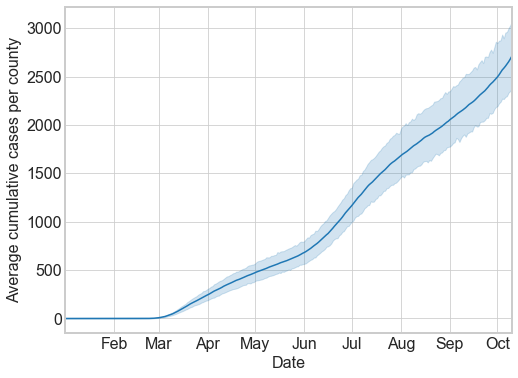

In [14]:
# cumulative cases
plt.figure(figsize=(8,6))
g=sns.lineplot(x="date", y="cases",
             data=df_merge)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlim(df_merge['date'].min(),df_merge['date'].max())
g.set_xlabel('Date')
g.set_ylabel('Average cumulative cases per county')
plt.show()

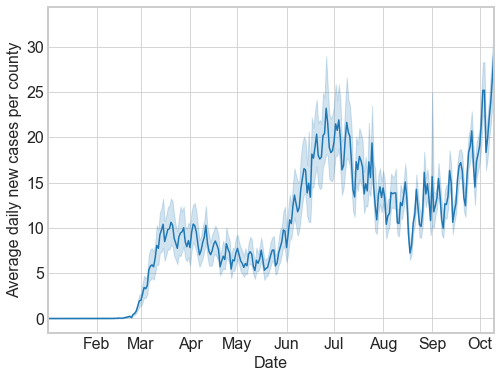

In [15]:
# new cases
plt.figure(figsize=(8,6))
g=sns.lineplot(x="date", y="new_cases",
             data=df_merge)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlim(df_merge['date'].min(),df_merge['date'].max())
g.set_xlabel('Date')
g.set_ylabel('Average daily new cases per county')
plt.show()

We see a clear weekly circular patterns in the newly confirmed cases.

## Policies

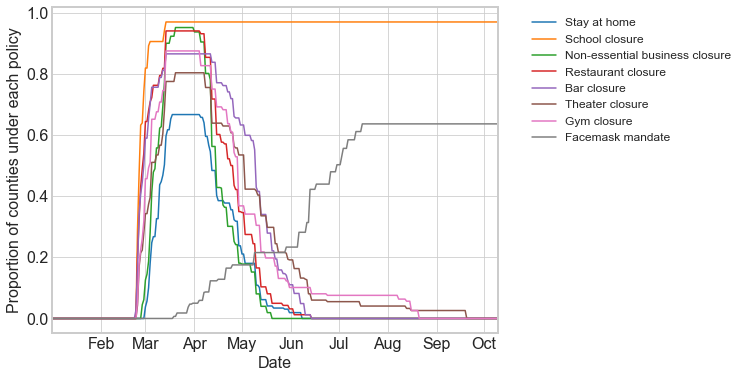

In [63]:
plt.figure(figsize=(8,6))
g=sns.lineplot(x="date", y="policy_home",ci=None,label="Stay at home",
             data=df_merge)
sns.lineplot(x="date", y="policy_school",ci=None,label="School closure",
             data=df_merge)
sns.lineplot(x="date", y="policy_business",ci=None,label="Non-essential business closure",
             data=df_merge)
sns.lineplot(x="date", y="policy_restaurant",ci=None,label="Restaurant closure",
             data=df_merge)
sns.lineplot(x="date", y="policy_bar",ci=None,label="Bar closure",
             data=df_merge)
sns.lineplot(x="date", y="policy_theater",ci=None,label="Theater closure",
             data=df_merge)
sns.lineplot(x="date", y="policy_gym",ci=None,label="Gym closure",
             data=df_merge)
sns.lineplot(x="date", y="policy_facemask",ci=None,label="Facemask mandate",
             data=df_merge)


locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlim(df_merge['date'].min(),df_merge['date'].max())
g.set_xlabel('Date')
g.set_ylabel('Proportion of counties under each policy')
plt.legend(fontsize='large',bbox_to_anchor=(1.05, 1),loc='upper left')
plt.show()

# Correlational Analysis

Plot the case growth by early and late adopter of "Stay-at-home"/"Shelter-in-place" policy.

In [17]:
medium_order=df_merge['stay_at_home'].astype('datetime64[ns]').quantile(.5)
df_merge['early_adopter']=np.where((df_merge['stay_at_home'].astype('datetime64[ns]')<medium_order)
                                   & df_merge['stay_at_home'].notna()==True,1,0)
df_merge['late_adopter']=np.where((df_merge['stay_at_home'].astype('datetime64[ns]')>=medium_order)
                                   & df_merge['stay_at_home'].notna()==True,1,0)
df_merge['never_adopter']=np.where(df_merge['stay_at_home'].notna()==False,1,0)

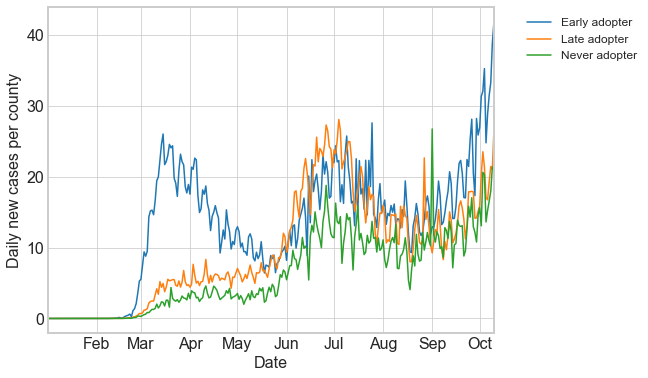

In [17]:
plt.figure(figsize=(8,6))
g=sns.lineplot(x="date", y="new_cases",ci=None,label="Early adopter",
             data=df_merge[df_merge['early_adopter']==1])
sns.lineplot(x="date", y="new_cases",ci=None,label="Late adopter",
             data=df_merge[df_merge['late_adopter']==1])
sns.lineplot(x="date", y="new_cases",ci=None,label="Never adopter",
             data=df_merge[df_merge['never_adopter']==1])

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlim(df_merge['date'].min(),df_merge['date'].max())
g.set_xlabel('Date')
g.set_ylabel('Daily new cases per county')
plt.legend(fontsize='large',bbox_to_anchor=(1.05, 1),loc='upper left')
plt.show()

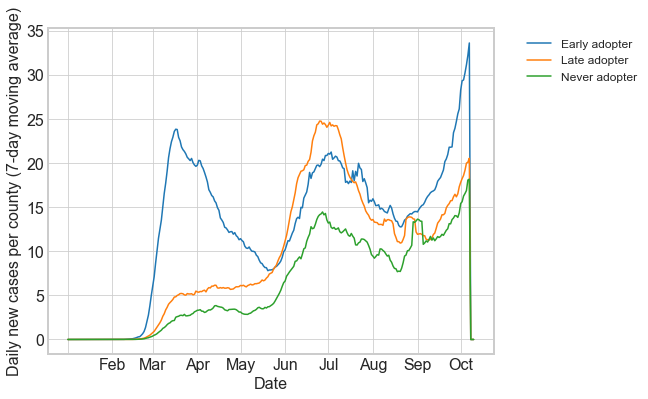

In [18]:
plt.figure(figsize=(8,6))
g=sns.lineplot(x="date", y="cases_7day_ave",ci=None,label="Early adopter",
             data=df_merge[df_merge['early_adopter']==1])
sns.lineplot(x="date", y="cases_7day_ave",ci=None,label="Late adopter",
             data=df_merge[df_merge['late_adopter']==1])
sns.lineplot(x="date", y="cases_7day_ave",ci=None,label="Never adopter",
             data=df_merge[df_merge['never_adopter']==1])

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlabel('Date')
g.set_ylabel('Daily new cases per county (7-day moving average)')
plt.legend(fontsize='large',bbox_to_anchor=(1.05, 1),loc='upper left')
plt.show()

In [14]:
df_merge['log_cum_cases']=np.log(df_merge['cases']+1)
df_merge['log_case_diff']=df_merge['log_cum_cases'].groupby(df_merge['fips']).diff().fillna(0)
df_merge['date']=pd.to_datetime(df_merge['date'],format='%Y-%m-%d')

In [15]:
# df_complete=df_merge.dropna(subset=['cases_7day_ave'])
# df_complete['log_cases']=np.log(df_complete['new_cases']+1)
# df_complete['log_case_diff']=df_complete['log_new_cases'].groupby(df_complete['fips']).diff().fillna(0)
# df_complete['date']=pd.to_datetime(df_complete['date'],format='%Y-%m-%d')

In [19]:
X=df_merge[['policy_home','policy_school','policy_business','policy_restaurant',
              'policy_gym','policy_bar','policy_theater','policy_facemask']]
y=df_merge['log_case_diff']

model = LinearRegression()
model.fit(X,y)
print(model.coef_)

[-0.00485617  0.01667805  0.00191768  0.0306465  -0.00077717  0.00401834
 -0.00483099 -0.01038085]


In [21]:
import statsmodels.formula.api as sm
normal_ols = sm.ols(formula='log_case_diff ~ policy_home + policy_school+ policy_business+ policy_restaurant+policy_gym+policy_bar+policy_theater+ policy_facemask',
                          data=df_merge).fit()
print(normal_ols.summary())

                            OLS Regression Results                            
Dep. Variable:          log_case_diff   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2566.
Date:                Sun, 08 Nov 2020   Prob (F-statistic):               0.00
Time:                        09:15:49   Log-Likelihood:             7.9798e+05
No. Observations:              945220   AIC:                        -1.596e+06
Df Residuals:                  945211   BIC:                        -1.596e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0071      0.00

In [41]:
# !pip3 install linearmodels

In [42]:
# from linearmodels.panel import PanelOLS

# panel_data = df_merge.loc[(df_merge['date']>=pd.to_datetime("2020-03-01",format='%Y-%m-%d')) &
#                              (df_merge['date']<=pd.to_datetime("2020-05-30",format='%Y-%m-%d'))].set_index(['fips', 'date'])
# panel_data.head()

In [28]:
# X=panel_data[['policy_home','policy_school','policy_business','policy_restaurant',
#               'policy_gym','policy_bar','policy_theater','policy_facemask']]
# y=panel_data['log_case_diff']
# reg  = PanelOLS(y,X, entity_effects=True)
# print(reg.fit())

## PCA

In [29]:
X=df_merge[['policy_home','policy_school','policy_business','policy_restaurant',
              'policy_gym','policy_bar','policy_theater','policy_facemask']]
y=df_merge['log_case_diff']

X_train, X_test, y_train, y_test  = train_test_split(
    X, y, test_size=0.25, random_state = 109)

In [36]:
pca = PCA().fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print('Train PCA dimensions:', X_train_pca.shape)
print('Test PCA dimensions:', X_test_pca.shape)

Train PCA dimensions: (708915, 8)
Test PCA dimensions: (236305, 8)


In [37]:
var_pca1=pca.explained_variance_ratio_[0]
var_pca2=pca.explained_variance_ratio_[1]
print(f"PCA1 explains {var_pca1.round(4)} of the variance, while PCA2 explains {var_pca2.round(4)}.")

PCA1 explains 0.5458 of the variance, while PCA2 explains 0.2082.


This indicates that the social distancing policies are highly correlated in their implementation places and time, thus including them all may cause multi-collinearity problem.  

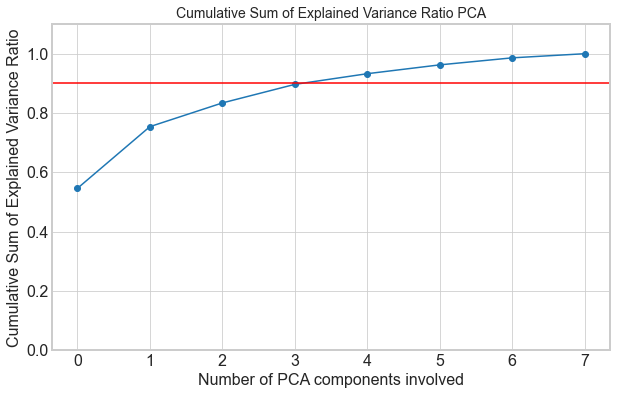

In [38]:
plt.figure(figsize=(10,6))

ratio = pca.explained_variance_ratio_
plt.plot(np.cumsum(ratio), 'o-')
plt.axhline(0.9,color='r')
plt.title('Cumulative Sum of Explained Variance Ratio PCA', fontsize=14)
plt.ylim(0,1.1)
plt.ylabel('Cumulative Sum of Explained Variance Ratio')
plt.xlabel("Number of PCA components involved")

plt.show()

In [49]:
list(X_train.columns)

['policy_home',
 'policy_school',
 'policy_business',
 'policy_restaurant',
 'policy_gym',
 'policy_bar',
 'policy_theater',
 'policy_facemask']

In [53]:
pca.components_[:2]

array([[ 0.29356958,  0.16174288,  0.36580302,  0.43177013,  0.43465663,
         0.4396433 ,  0.41169276, -0.1253607 ],
       [-0.00404551,  0.60091192, -0.02759107, -0.03264556,  0.04506626,
        -0.0281996 ,  0.05011054,  0.79481082]])

Dimension 1: all the closures and social distancing;
Dimension 2: facemask and school

In [57]:
# Normal linear regression
reg_lr=LinearRegression()
reg_lr.fit(X_train,y_train)

y_test_pred = reg_lr.predict(X_test)
mse_score = cross_validate(reg_lr,X_train, y_train, cv=10,scoring="neg_mean_squared_error",return_train_score=True)

test_error=mean_squared_error(y_test_pred,y_test)
cross_validation_error=-mse_score['test_score'].mean()
r2_square = r2_score(y_test,y_test_pred)

print(f'The cross-validation MSE for normal linear regression is {cross_validation_error.round(4)}')
print(f'The testing MSE for normal linear regression is {test_error.round(4)}')
print(f"Test R-Squared score is {r2_square}")

The cross-validation MSE for normal linear regression is 0.0108
The testing MSE for normal linear regression is 0.011
Test R-Squared score is 0.021106055709428584


In [58]:
# PCA
pca = PCA(n_components=2).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

reg_pca = LinearRegression()
reg_pca.fit(X_train_pca,y_train)
mse_score_pca = cross_validate(reg_pca,X_train_pca, y_train, cv=10,scoring="neg_mean_squared_error",return_train_score=True)
y_pred_pca_test = reg_pca.predict(X_test_pca)

test_error_pca=mean_squared_error(y_pred_pca_test,y_test)
cross_validation_error_pca=-mse_score_pca['test_score'].mean()
r2_square = r2_score(y_test,y_pred_pca_test)

print(f"The cross-validation MSE of 2 component PCA is {cross_validation_error_pca.round(4)} ")
print(f"The testing MSE of 2 component PCA is {test_error_pca.round(4)} ")
print(f"Test R-Squared score is {r2_square}")

The cross-validation MSE of 2 component PCA is 0.0108 
The testing MSE of 2 component PCA is 0.0111 
Test R-Squared score is 0.016092129074217865
